# Predicting Grade

The second step is to use the approved loans dataset to predict the grade,
sub-grade, and interest rate. Let us start with the grade.

## Exploratory Data Analysis

First, we import the libraries we are going to use.

In [1]:
import sqlite3

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from pycaret.classification import *
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split

from script import make_mi_scores, plot_mi_scores, filter_columns, \
    downgrade_column_types, encode_binary_columns, one_hot_encode_common_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


For this part of the project, we will only use the information from the
dataset known prior to determining the fields we are going to predict. That
is why we have created a new view for it.

In [2]:
conn = sqlite3.connect('rejected_2007_to_2018Q4.db')
cursor = conn.cursor()

In [3]:
df = pd.read_sql_query("""
SELECT * FROM accepted_relevant
""", conn)

In [4]:
df.head()

,id,Number_Trades_24_Months,State,Balance_Credit_Limit,Annual_Income,Application_Type,Total_Open_Buy,Number_Delinquent_2_Years,Delinquent_Amount,Disbursement_Method,...,Number_Bankcard_Accounts,Number_Installment_Accounts,Percent_Trades_Never_Delinquent,Percent_Bankcard_Accounts_Greater_75,Number_Derogatory_Public_Records,Number_Public_Records_Bankruptcies,Total_Credit_Revolving_Balance,Sub_Grade,Tax_Liens,Term_In_Months
0,68407277,4.0,PA,34.0,55000.0,Individual,1506.0,0.0,0.0,Cash,...,5.0,3.0,76.9,0.0,0.0,0.0,2765.0,C4,0.0,36
1,68355089,4.0,SD,29.0,65000.0,Individual,57830.0,1.0,0.0,Cash,...,17.0,6.0,97.4,7.7,0.0,0.0,21470.0,C1,0.0,36
2,68341763,6.0,IL,65.0,67000.0,Joint App,2737.0,0.0,0.0,Cash,...,4.0,6.0,100.0,50.0,0.0,0.0,7869.0,B4,0.0,60
3,66310712,2.0,NJ,45.0,110000.0,Individual,54962.0,0.0,0.0,Cash,...,10.0,2.0,100.0,0.0,0.0,0.0,7802.0,C5,0.0,60
4,68476807,10.0,PA,78.0,104433.0,Individual,4567.0,1.0,0.0,Cash,...,9.0,10.0,96.6,60.0,0.0,0.0,21929.0,F1,0.0,60


As we can see, we have a large number of columns and rows. Therefore, we are
going to do our best to optimise our dataset. First of all, we are going to
remove columns with more than 25% of their data missing, and we are going to
encode columns with only two values.

In [5]:
df = filter_columns(df)
df = encode_binary_columns(df)

In [6]:
df.memory_usage(deep=True).sum()

3834520813

Now, to reduce memory usage, we are going to use the smallest data type
possible without losing any information.

As for the profession, we are going to one hot encode it using the fifty most
 common professions in the dataset.

In [7]:
df = downgrade_column_types(df)

In [48]:
nltk.download('stopwords')
stop_words = stopwords.words()
stop_words.append('&')


def get_most_common_words(column, number_word_combination=1,
                          number_results=50) -> pd.Series:
    words = " ".join(column.str.lower()).split()
    word_combos = []
    word_combo = []
    for i in range(len(words) - (number_word_combination - 1)):
        for j in range(number_word_combination):
            word_combo.append(words[i + j])
        if set(word_combo).isdisjoint(stop_words):
            word_combos.append(' '.join(word_combo))
        word_combo.clear()
    return pd.Series(word_combos).value_counts()[:number_results]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
most_common_words = get_most_common_words(df['Employment_Title'],
                                          number_results=50)

In [50]:
most_common_words.index

Index(['manager', 'director', 'assistant', 'sales', 'senior', 'nurse',
       'supervisor', 'teacher', 'specialist', 'engineer', 'analyst', 'driver',
       'service', 'registered', 'officer', 'technician', 'owner',
       'coordinator', 'tech', 'operations', 'operator', 'project', 'associate',
       'office', 'president', 'lead', 'executive', 'business', 'consultant',
       'general', 'account', 'customer', 'administrator', 'clerk', 'services',
       'medical', 'vice', 'support', 'truck', 'maintenance', 'program',
       'administrative', 'accountant', 'financial', 'systems', 'security',
       'mechanic', 'software', 'management', 'marketing'],
      dtype='object')

In [9]:
most_common_words = ['manager', 'director', 'assistant', 'sales', 'senior',
                     'nurse',
                     'supervisor', 'teacher', 'specialist', 'engineer',
                     'analyst', 'driver',
                     'service', 'registered', 'officer', 'technician', 'owner',
                     'coordinator', 'tech', 'operations', 'operator', 'project',
                     'associate',
                     'office', 'president', 'lead', 'executive', 'business',
                     'consultant',
                     'general', 'account', 'customer', 'administrator', 'clerk',
                     'services',
                     'medical', 'vice', 'support', 'truck', 'maintenance',
                     'program',
                     'administrative', 'accountant', 'financial', 'systems',
                     'security',
                     'mechanic', 'software', 'management', 'marketing']

In [16]:
most_common_words

manager           301350
director           75597
assistant          72552
sales              71924
nurse              62355
supervisor         57756
teacher            57042
specialist         54717
senior             53140
engineer           52307
analyst            50439
driver             50372
service            44182
registered         43528
officer            41575
technician         41449
owner              37470
coordinator        31861
tech               31561
operations         30815
operator           30161
project            28139
associate          26632
office             26075
president          25817
lead               24297
executive          23556
business           21621
consultant         21001
general            20255
account            20064
customer           18777
administrator      18117
clerk              17360
sr.                17084
services           16973
medical            16800
vice               16464
support            15921
truck              15417


In [10]:
df = one_hot_encode_common_words(df, 'Grade', most_common_words)

TypeError: 'RangeIndex' object is not callable

In [ ]:
df.memory_usage(deep=True).sum()

In [ ]:
df.head()

In [37]:
df.dtypes

id                                Int32
Number_Trades_24_Months            Int8
State                          category
Annual_Income                   float64
Total_Open_Buy                    Int32
                                 ...   
Employment_Title_Security          Int8
Employment_Title_Mechanic          Int8
Employment_Title_Software          Int8
Employment_Title_Management        Int8
Employment_Title_Marketing         Int8
Length: 106, dtype: object

In [17]:
df.shape

(2260668, 106)

Let us save our dataset in a pickle file so we can use it for the remaining two projects.

In [31]:
df.to_pickle('./df.pkl')

## Exploratory Data Analysis

Since we have so many columns, we are going to focus on the ones with the
highest mutual information scores.

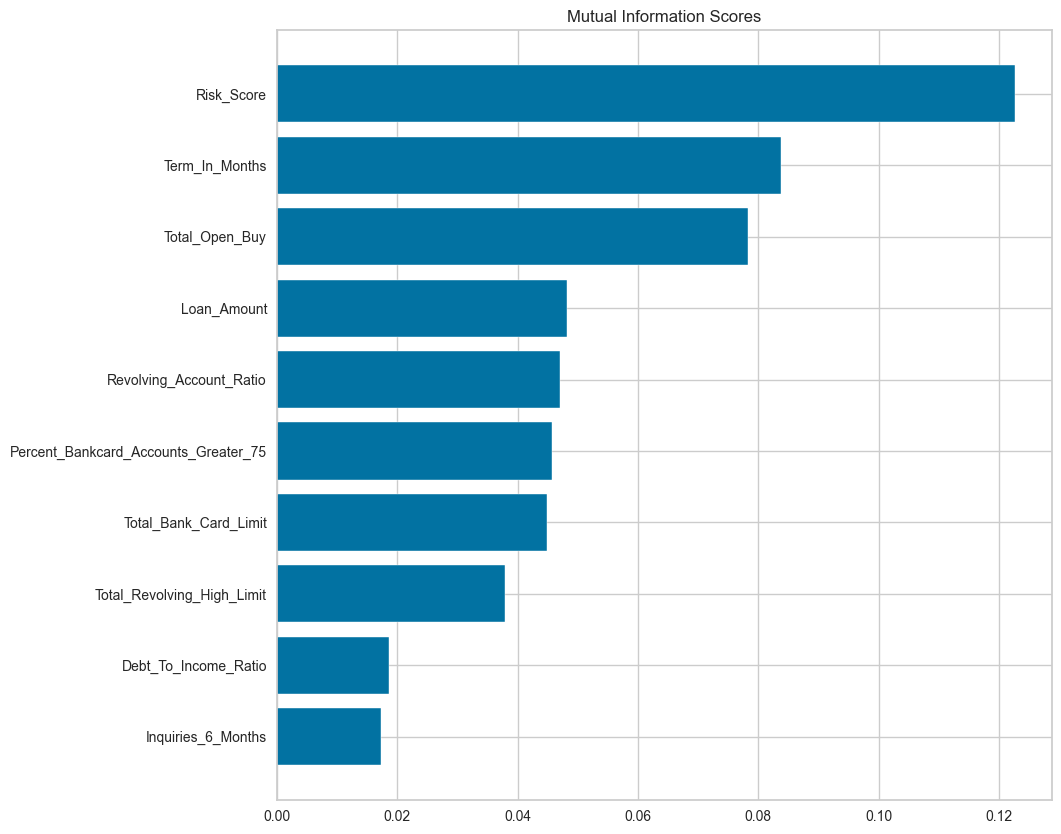

In [39]:
sample = df.sample(frac=0.05, random_state=42).dropna()
mi_scores = make_mi_scores(
    sample.drop(['Grade', 'Sub_Grade', 'Interest_Rate', 'id'], axis=1)
    .select_dtypes
    (include=np.number), sample['Grade'])

plt.figure(dpi=100, figsize=(10, 10))
plot_mi_scores(mi_scores.nlargest(10))

Now we are going to plot these ten features by grade to see if we can detect
any patterns. For visibility purposes, we are going to exclude outliers.

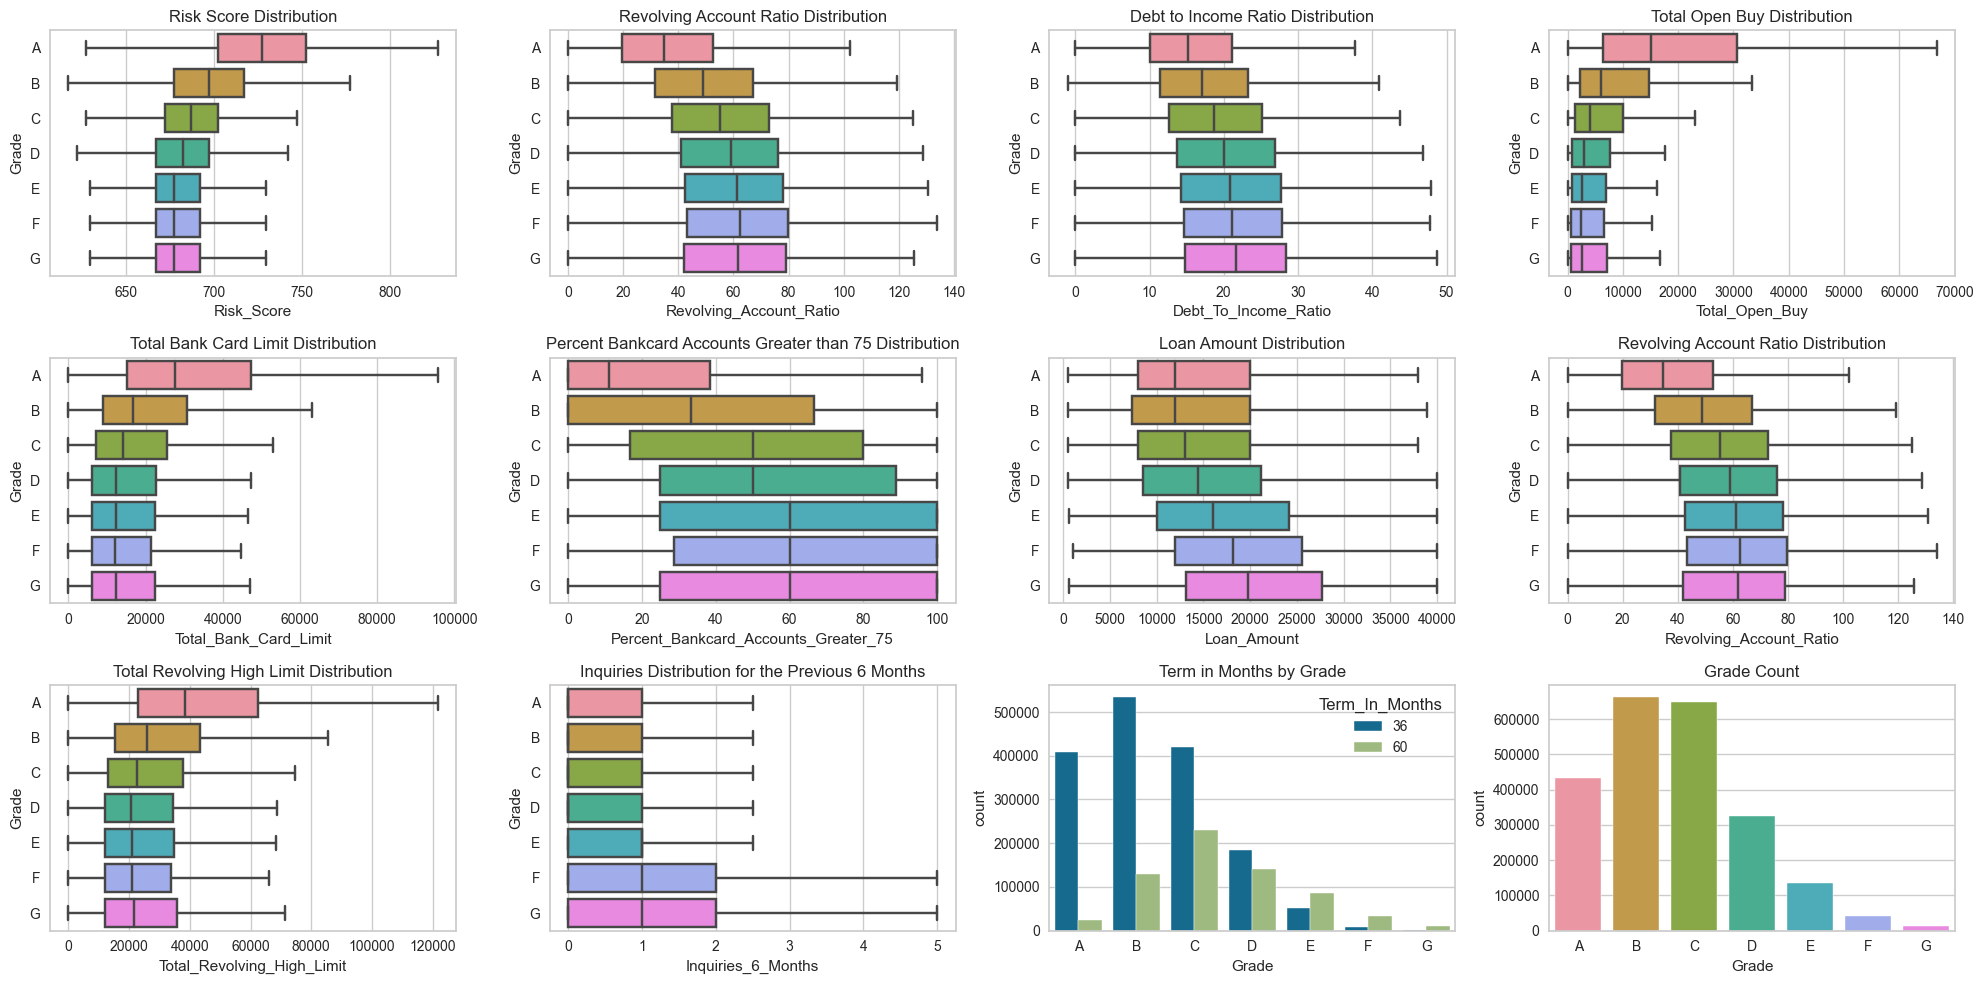

In [40]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

sns.boxplot(data=df, x='Risk_Score', y='Grade', showfliers=False,
            ax=axes[0, 0])
axes[0, 0].set_title('Risk Score Distribution')

sns.boxplot(data=df, x='Revolving_Account_Ratio', y='Grade', showfliers=False,
            ax=axes[0, 1])
axes[0, 1].set_title('Revolving Account Ratio Distribution')

sns.boxplot(data=df, x='Debt_To_Income_Ratio', y='Grade', showfliers=False,
            ax=axes[0, 2])
axes[0, 2].set_title('Debt to Income Ratio Distribution')

sns.boxplot(data=df, x='Total_Open_Buy', y='Grade', showfliers=False,
            ax=axes[0, 3])
axes[0, 3].set_title('Total Open Buy Distribution')

sns.boxplot(data=df, x='Total_Bank_Card_Limit', y='Grade', showfliers=False,
            ax=axes[1, 0])
axes[1, 0].set_title('Total Bank Card Limit Distribution')

sns.boxplot(data=df, x='Percent_Bankcard_Accounts_Greater_75', y='Grade',
            showfliers=False,
            ax=axes[1, 1])
axes[1, 1].set_title('Percent Bankcard Accounts Greater than 75 Distribution')

sns.boxplot(data=df, x='Loan_Amount', y='Grade', showfliers=False,
            ax=axes[1, 2])
axes[1, 2].set_title('Loan Amount Distribution')

sns.boxplot(data=df, x='Revolving_Account_Ratio', y='Grade', showfliers=False,
            ax=axes[1, 3])
axes[1, 3].set_title('Revolving Account Ratio Distribution')

sns.boxplot(data=df, x='Total_Revolving_High_Limit', y='Grade',
            showfliers=False,
            ax=axes[2, 0])
axes[2, 0].set_title('Total Revolving High Limit Distribution')

sns.boxplot(data=df, x='Inquiries_6_Months', y='Grade', showfliers=False,
            ax=axes[2, 1])
axes[2, 1].set_title('Inquiries Distribution for the Previous 6 Months')

sns.countplot(x=df.Grade, hue=df.Term_In_Months, ax=axes[2, 2])
axes[2, 2].set_title('Term in Months by Grade')

grade_order = sorted(df['Grade'].unique())
sns.countplot(x=df.Grade, order=grade_order, ax=axes[2, 3])
axes[2, 3].set_title('Grade Count')

plt.tight_layout()
plt.show()

As we can see in all subplots, there is either a decreasing or increasing
trend from grade A to grade G, which may indicate a correlation between the
feature at hand and the grade granted.

In [84]:
features_highest_mi = mi_scores.nlargest(10).index

In [107]:
df_filtered = df[features_highest_mi]
df_filtered['Grade_Numeric'] = df['Grade'].replace(
    {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}).astype('Int8')

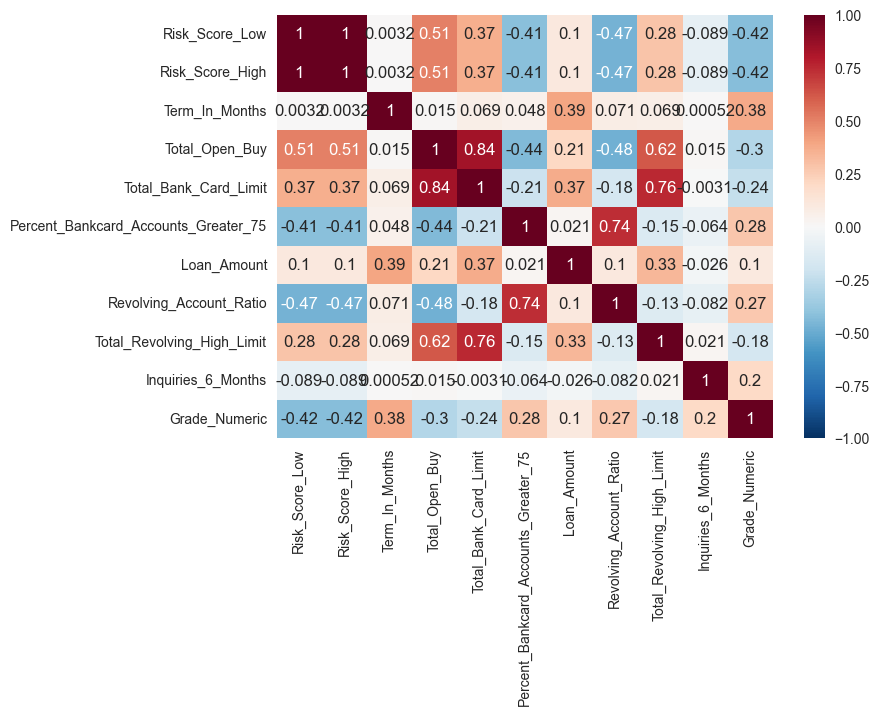

In [108]:
sns.heatmap(
    df_filtered.corr(numeric_only=True),
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1)
plt.show()

## Statistical Analysis

For this statistical analysis, we want to find out whether there is a
significant difference between the different grades across various features. To
achieve this, we will use Chi-Square and ANOVA.

Chi-Square Test
For a categorical independent variable $x$ and a categorical dependent variable
$y$ (grade):

$H_0$: There is no relationship between $x$ and the likelihood of $y$ (grade).
Chi-square $= 0$
$H_1$: There is a significant relationship between $x$ and the likelihood of $y$. Chi-square $\neq 0$
We applied the Chi-Square test to examine the association between binary
features and the approval of loans. The test evaluates whether the
distribution of approved loans differs significantly based on the categories
 of the examined feature.

ANOVA (Analysis of Variance)
For categorical features with more than two levels, we applied the Analysis of Variance (ANOVA) test. ANOVA assesses whether there are statistically significant differences in means across multiple groups. The hypotheses for ANOVA are similar to those of the z-test, testing for differences in average values among categories of the categorical feature. The resulting F-statistic and p-value from ANOVA help determine if there is a significant overall effect of the categorical variable on loan approval.

In [19]:
numerical_variables = df.dropna().select_dtypes(include=float).columns

for variable in numerical_variables:
    data_by_grade = [df[df['Grade'] == grade][variable] for grade in
                     ['A', 'B', 'C', 'D', 'E', 'F', 'G']]
    anova_results = f_oneway(*data_by_grade)
    print(
        f"ANOVA results for variable '{variable}': F-statistic={anova_results.statistic}, p-value={anova_results.pvalue}")


ANOVA results for variable 'Annual_Income': F-statistic=nan, p-value=nan
ANOVA results for variable 'Debt_To_Income_Ratio': F-statistic=10300.713469962955, p-value=0.0
ANOVA results for variable 'Interest_Rate': F-statistic=3755384.0866093272, p-value=0.0
ANOVA results for variable 'Risk_Score': F-statistic=117745.4198060131, p-value=0.0
ANOVA results for variable 'Inquiries_6_Months': F-statistic=nan, p-value=nan
ANOVA results for variable 'Mortgage_Accounts': F-statistic=nan, p-value=nan
ANOVA results for variable 'Open_Trades': F-statistic=nan, p-value=nan
ANOVA results for variable 'Revolving_Account_Ratio': F-statistic=nan, p-value=nan
ANOVA results for variable 'Revolving_Balance': F-statistic=457.0953943808033, p-value=0.0
ANOVA results for variable 'Number_Revolving_Accounts': F-statistic=nan, p-value=nan
ANOVA results for variable 'Number_Charge_Offs_12_Months': F-statistic=nan, p-value=nan
ANOVA results for variable 'Number_Collections_12_Months': F-statistic=nan, p-value=nan

In [20]:
categorical_variables = ['State', 'Home_Ownership',
                         'Loan_Purpose', 'Verification_Status'
                         ]
contingency_tables = {}
for variable in categorical_variables:
    contingency_table = pd.crosstab(df['Grade'], df[variable])
    contingency_table_normalised = pd.crosstab(df['Grade'], df[variable],
                                               normalize='index')
    contingency_tables[variable] = contingency_table_normalised.transpose()
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(
        f"Chi-square test results for variable '{variable}': chi2={chi2}, p-value={p_value}")


Chi-square test results for variable 'State': chi2=3448.955300346514, p-value=0.0
Chi-square test results for variable 'Home_Ownership': chi2=14908.599709602067, p-value=0.0
Chi-square test results for variable 'Loan_Purpose': chi2=78876.71683613455, p-value=0.0
Chi-square test results for variable 'Verification_Status': chi2=140465.05241631213, p-value=0.0


In [21]:
employment_title_columns = [col for col in df.columns if col
.startswith("Employment_Title_") or col.startswith('Grade')]
df_selected = df[employment_title_columns]

In [22]:
employment_counts = df_selected.groupby("Grade").sum()

employment_counts = employment_counts.transpose()

chi2, p_value, dof, expected = chi2_contingency(employment_counts)
print(
    f"Chi-square test results for Employment Titles: chi2={chi2}, p-value={p_value}")

Chi-square test results for Employment Titles: chi2=17211.231515832726, p-value=0.0


Based on the above results, we can reject the null hypothesis for all tested
features.

## Statistical Modelling

In this case, we are going to predict the grade an accepted loan would get.
Because grades can go from A to G, this will be a multiclass classification
model. We are also going to use PyCaret for this, as well as for all
subsequent models.

### Data Split

We are going to follow a similar approach for data split: split into train and test and stratify the dependent feature to deal with imbalanced classes.

In [7]:
X = df.drop(['id', 'Grade', 'Interest_Rate', 'Sub_Grade'], axis=1)
y = df['Grade']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    stratify=y,
                                                    random_state=42)

In [21]:
print(f'Number of Samples (and features by Grade) by set: \n - Train: '
      f'{len(X_train)} ('
      f'A: {y_train.value_counts().get(0)}, '
      f'B: {y_train.value_counts().get(1)}, '
      f'C: {y_train.value_counts().get(2)}, '
      f'D: {y_train.value_counts().get(3)}, '
      f'E: {y_train.value_counts().get(4)}, '
      f'F: {y_train.value_counts().get(5)}, '
      f'G: {y_train.value_counts().get(6)}) '
      f' \n'
      f' - Test: {len(X_test)} ('
      f'A: {y_test.value_counts().get(0)}, '
      f'B: {y_test.value_counts().get(1)}, '
      f'C: {y_test.value_counts().get(2)}, '
      f'D: {y_test.value_counts().get(3)}, '
      f'E: {y_test.value_counts().get(4)}, '
      f'F: {y_test.value_counts().get(5)}, '
      f'G: {y_test.value_counts().get(6)}) ')

Number of Samples (and features by Grade) by set: 
 - Train: 1582467 (A: 464490, B: 455037, C: 303119, D: 227097, E: 94947, F: 29260, G: 8517)  
 - Test: 678201 (A: 199067, B: 195016, C: 129908, D: 97327, E: 40692, F: 12540, G: 3651) 


Next, we are going to set up a session to automate preprocessing and get our pipeline ready.

In [12]:
s = setup(pd.concat([X_train, y_train], axis=1), target='Grade', session_id=123,
          fix_imbalance=True)


,Description,Value
0,Session id,123
1,Target,Grade
2,Target type,Multiclass
3,Target mapping,"A: 0, B: 1, C: 2, D: 3, E: 4, F: 5, G: 6"
4,Original data shape,"(1582467, 103)"
5,Transformed data shape,"(2750742, 123)"
6,Transformed train set shape,"(2276001, 123)"
7,Transformed test set shape,"(474741, 123)"
8,Numeric features,98
9,Categorical features,4


Then, we are going to compare different classification models to choose the one with the best F1 score.

Alternatively, you can run `best_model = load_model
('grade/model_grade_not_tuned')` to get the chosen model.

In [24]:
best_model = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.2537,0.0000,0.2537,0.2470,0.2416,0.1694,0.1722,577.6100


Now, let us tune its hyperparameters.

Alternatively, you can run `tuned_best_model = load_model
('grade/model_grade_tuned')
` to get the tuned model.

In [ ]:
tuned_best_model = tune_model(best_model, optimize='F1', tuner_verbose=3)

We already check the model's performance using `evaluate_model`, which will show several plots to illustrate how good our model is at predicting loan grades.

In [ ]:
evaluate_model(tuned_best_model)

Now, all we need to do is finalise it and test it with the test set.

In [14]:
final_best_model = finalize_model(tuned_best_model)

In [16]:
pred_unseen = predict_model(tuned_best_model,
                            pd.concat([X_test, y_test], axis=1))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5059,0.7975,0.5059,0.4929,0.4810,0.3365,0.3423


Now we can save it and deploy it

In [15]:
save_model(final_best_model, 'grade/model_grade_finalized')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\guill\AppData\Local\Temp\joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Number_Trades_24_Months',
                                              'Annual_Income', 'Total_Open_Buy',
                                              'Number_Delinquent_2_Years',
                                              'Delinquent_A...
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.15,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                max_depth=7, max_leaves=None, min